## LSTM Keras method for stock prediction

https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

### Load the dataset

In [2]:
start = pd.to_datetime('2016-01-01')
df = web.DataReader("^FCHI", data_source = 'yahoo', start = start )

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,4586.109863,4490.299805,4582.049805,4522.450195,130633900.0,4522.450195
2016-01-05,4575.450195,4481.700195,4573.540039,4537.629883,104182900.0,4537.629883
2016-01-06,4533.240234,4440.770020,4528.120117,4480.470215,104877300.0,4480.470215
2016-01-07,4424.140137,4323.549805,4346.100098,4403.580078,137701000.0,4403.580078
2016-01-08,4437.020020,4333.740234,4404.180176,4333.759766,124197200.0,4333.759766


In [5]:
df.isnull().values.any()

False

In [6]:
data = df [['Close']]
data = data.reset_index()

training_data = data[data['Date'] < pd.to_datetime('2020-01-01')].copy()
test_data = data[data['Date'] >= pd.to_datetime("2020-01-01")].copy()

training_data = training_data.set_index('Date')
test_data = test_data.set_index('Date')

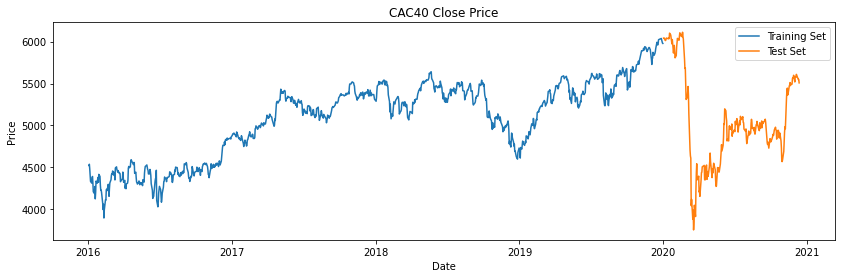

In [7]:
plt.figure(figsize=(14,4))
plt.plot(training_data.Close)
plt.plot(test_data.Close)
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(["Training Set", "Test Set"])
plt.title("CAC40 Close Price")
plt.show()

### Feature scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)

In [9]:
len(training_set_scaled)

1022

In [10]:
max(training_set_scaled)

array([1.])

### Creating Data with Timesteps

In [11]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Building the LSTM
 
In order to build the LSTM, we need to import a couple of modules from Keras:

    Sequential for initializing the neural network
    Dense for adding a densely connected neural network layer
    LSTM for adding the Long Short-Term Memory layer
    Dropout for adding dropout layers that prevent overfitting

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers

In [13]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

optimizer = optimizers.Adam(clipvalue=0.5)
regressor.compile(optimizer=optimizer, loss='mean_squared_error')

regressor.fit(X_train, y_train, epochs = 10, batch_size = 128)

Epoch 1/10
962/962 [==============================] - 4s 4ms/step - loss: 0.2194
Epoch 2/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0403
Epoch 3/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0263
Epoch 4/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0173
Epoch 5/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0149
Epoch 6/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0113
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0095
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0080
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0078
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.0076


### Predicting future stock

In [38]:
dataset_test = pd.read_csv('^FCHI_test.csv')
real_stock_price = dataset_test.iloc[:, 3:4].values

In [39]:
len(real_stock_price)

21

In order to predict future stock prices we need to do a couple of things after loading in the test set:

    Merge the training set and the test set on the 0 axis.
    Set the time step as 60 (as seen previously)
    Use MinMaxScaler to transform the new dataset
    Reshape the dataset as done previously
After making the predictions we use inverse_transform to get back the stock prices in normal readable format.

In [18]:
total_data = pd.concat((training_data, test_data), axis = 0)
inputs = total_data[len(total_data) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# shaping data from neural network
X_test = []
y_test = []

for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i,0])
    y_test.append(inputs[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
predicted_price = regressor.predict(X_test)
predicted_price = sc.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: 'CAC40_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=0)
predicted_price.index = test_data.index

### Plotting the results

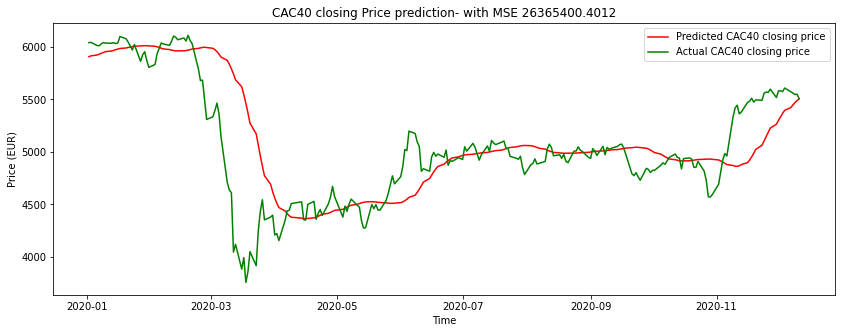

In [28]:
from sklearn.metrics import mean_squared_error
plt.figure(figsize = (14,5))
mse = mean_squared_error(y_test, predicted_price)

plt.plot(predicted_price['CAC40_predicted'], color = 'red', label = 'Predicted CAC40 closing price')
plt.plot(test_data.Close, color = 'green', label = 'Actual CAC40 closing price')
plt.title ("CAC40 closing Price prediction- with MSE {:10.4f}".format(mse))
plt.xlabel('Time')
plt.ylabel('Price (EUR)')
plt.legend()